In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob


from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from zipfile import ZipFile

data_path = '/content/drive/MyDrive/ADS_Exp_8/Lung_Image_Set.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [ ]:
path = '/content/Lung_Image_Set'
classes = os.listdir(path)
classes

['Malignant', 'Normal']

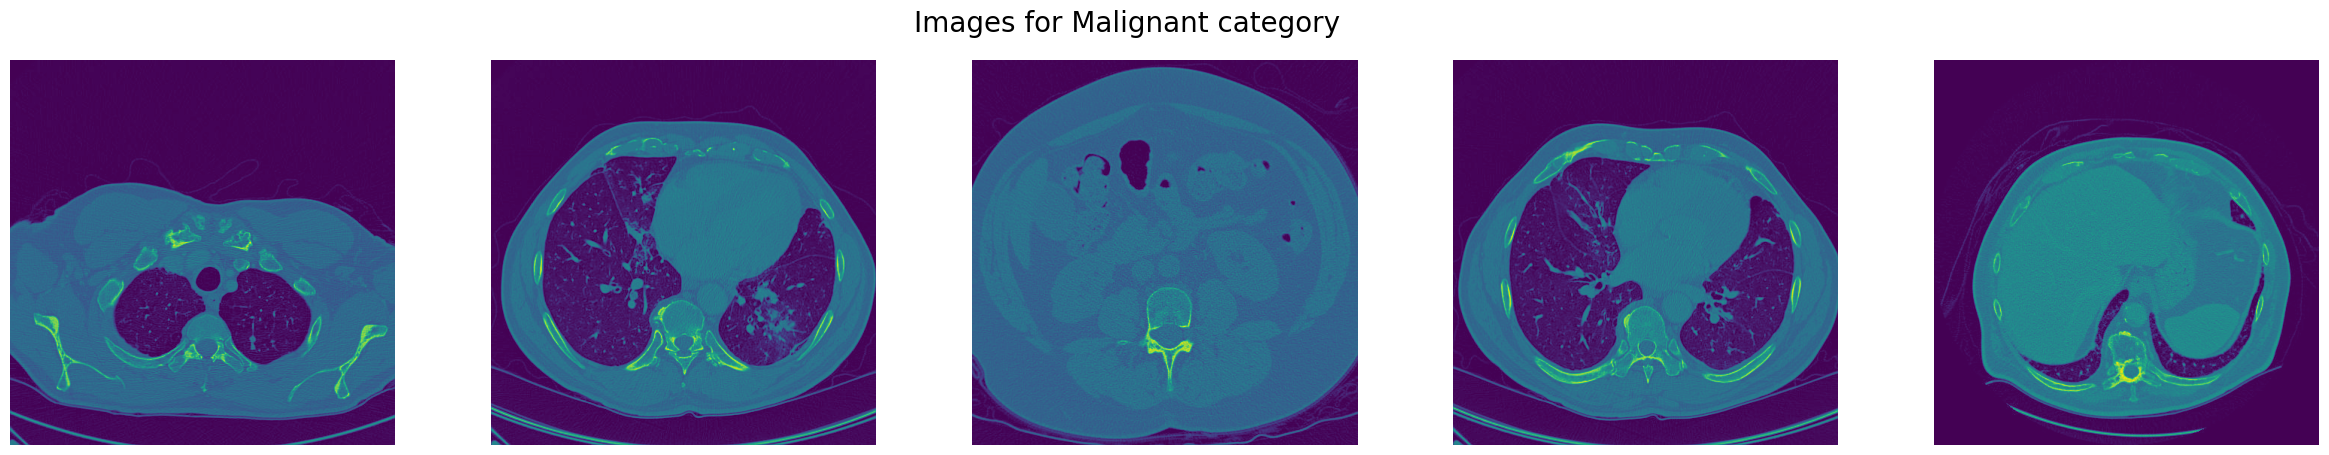

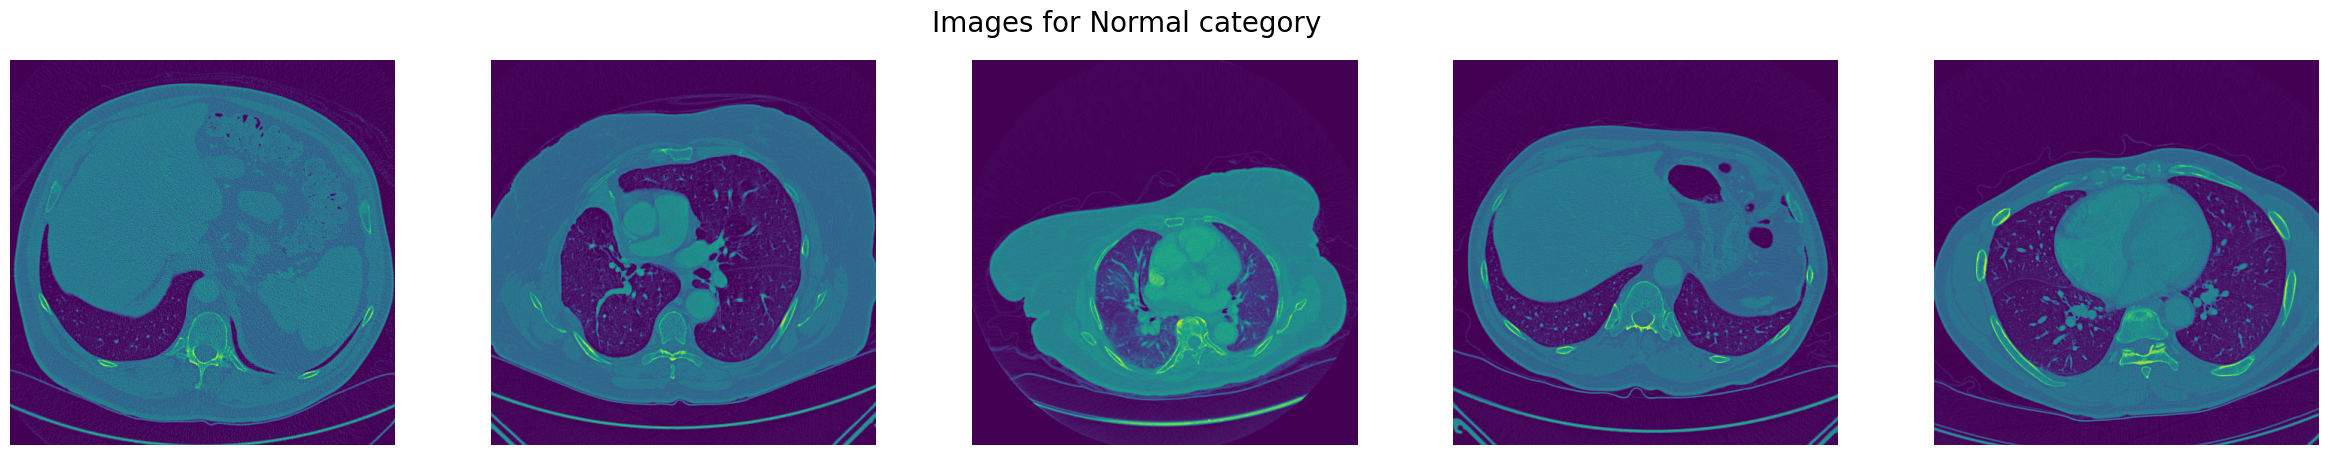

In [ ]:
path = '/content/Lung_Image_Set'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 5, figsize=(30, 5))
	fig.suptitle(f'Images for {cat} category', fontsize=20)

	for i in range(5):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()

In [ ]:
IMG_SIZE = 256
SPLIT = 0.3
EPOCHS = 10
BATCH_SIZE = 256

In [ ]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpg')

  for image in images:
	  img = cv2.imread(image)
	  X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
	  Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,random_state = 2022)

In [ ]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3),
               padding='same'), layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
               padding='same'), layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',
				padding='same'), layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(2, activation='softmax')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

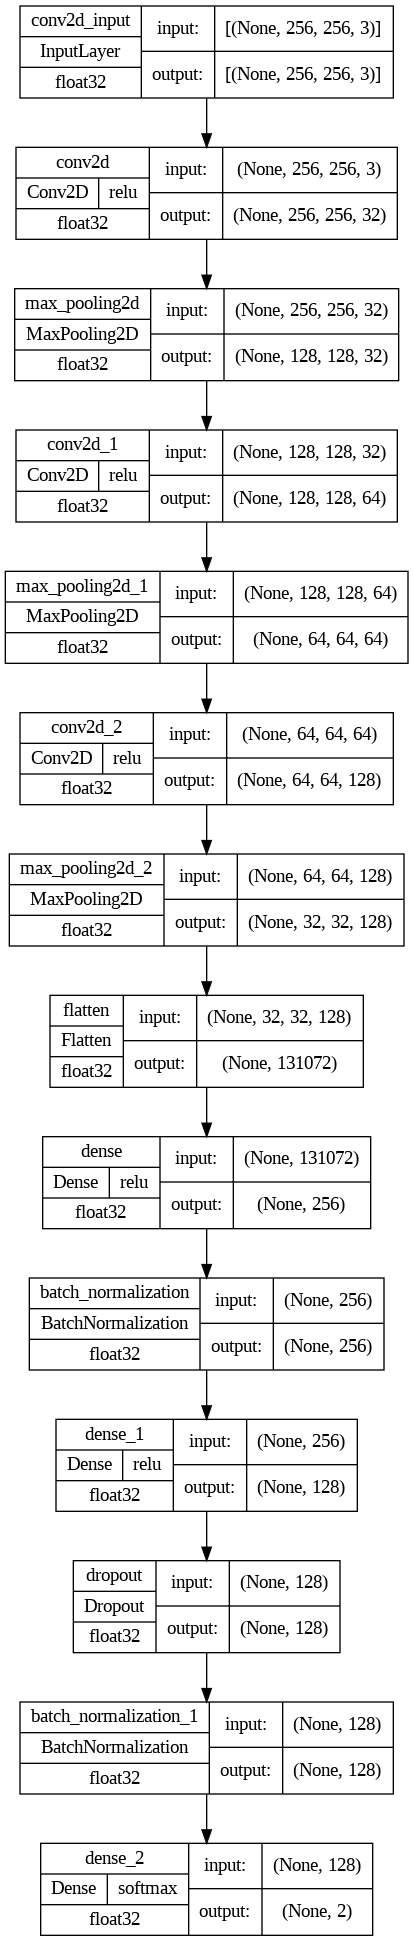

In [ ]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.98:
			print('\n Validation accuracy has reached upto \
					98% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

In [ ]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
6/9 [===================>..........] - ETA: 1s - loss: 0.3203 - accuracy: 0.8613

9/9 [==============================] - 39s 2s/step - loss: 0.2375 - accuracy: 0.8998 - val_loss: 8.7082 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 2/10
9/9 [==============================] - 5s 528ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 9.0971 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 3/10
9/9 [==============================] - 5s 555ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 4.9232 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 4/10
9/9 [==============================] - 5s 562ms/step - loss: 8.1910e-04 - accuracy: 1.0000 - val_loss: 2.6281 - val_accuracy: 0.5468 - lr: 0.0010
Epoch 5/10
9/9 [==============================] - 5s 550ms/step - loss: 5.9900e-04 - accuracy: 1.0000 - val_loss: 1.2766 - val_accuracy: 0.6093 - lr: 0.0010
Epoch 6/10
9/9 [==============================] - 5s 548ms/step - loss: 4.6706e-04 - accuracy: 1.0000 - val_loss: 0.5472 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 7/10
9/9 [==============================] - 5s 556ms/step - loss: 3.0355e-04 

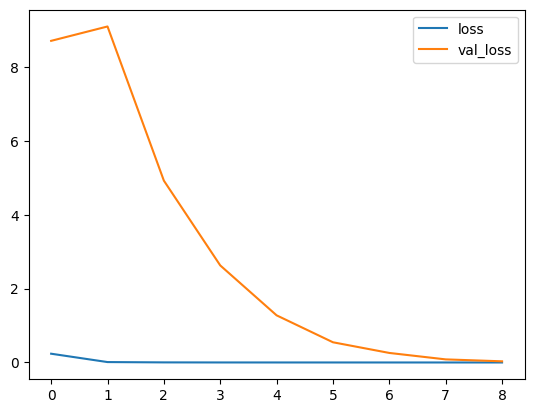

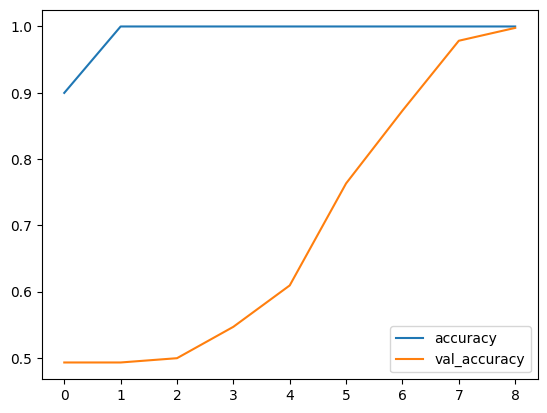

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [ ]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

30/30 [==============================] - 2s 23ms/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[469,   2],
       [  0, 458]])

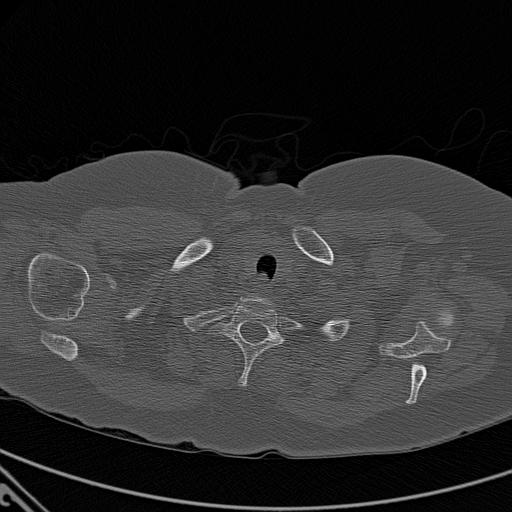

1/1 [==============================] - 0s 20ms/step
Malignant


In [ ]:
from google.colab.patches import cv2_imshow

user_img = cv2.imread("/content/M1.jpg")
X_img = cv2.resize(user_img, (IMG_SIZE, IMG_SIZE))
X_img = np.asarray(X_img)
X_img = np.reshape(X_img, [1, 256, 256, 3])
cv2_imshow(user_img)
predict_x = model.predict(X_img)
classes_x = np.argmax(predict_x, axis=1)
ans = classes_x[0]
if ans == 0:
    print('Malignant')
else:
    print('Normal')
